In [2]:
import torch
import numpy as np
import pandas as pd

from pyartm.vectorizer import CountVectorizer, TfidfVectorizer
from pyartm.thematizer import Thematizer
from pyartm.matrix_em import fit_em

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(palette='viridis')

In [3]:
def norm(x: torch.Tensor) -> torch.Tensor:
    x = torch.maximum(x, torch.tensor(0.0))
    x = x.transpose(0, 1)

    for i in range(len(x)):
        s = torch.sum(x[i])
        if s.data != 0:
            x[i] /= s

    return x.transpose(0, 1)

In [59]:
def fit_em(phi, theta, data, threshold=10):
    eps = 1e-9
    prev_loss = loss = torch.tensor(float('inf'))
    perplexity_list = []
    
    while True:
        print(loss)
        prev_loss = loss
        new_theta = theta
        theta = torch.rand(theta.shape)
        
        while torch.sum(torch.abs(new_theta - theta)) / (topic_count * doc_count) > 1e-2:
            theta = new_theta
            div = data / (torch.matmul(phi, theta) + eps)
            new_theta = norm(theta * torch.matmul(phi.transpose(0, 1), div))
            
        new_phi = norm(phi * torch.matmul(div, theta.transpose(0, 1)))
        
        phi = new_phi
        theta = new_theta

        #perplexity evaluation
        output = torch.matmul(phi, theta)
        loss = -torch.sum(data * torch.log(output + eps))
        loss /= torch.sum(data)
        loss = torch.exp(loss).item()

        perplexity_list.append(loss)
        
        if prev_loss - loss < threshold:
            break
            
    return perplexity_list

In [29]:
data = pd.Series(fetch_20newsgroups().data).iloc[:1000]
vectorizer = CountVectorizer()
data = vectorizer.fit_transform(data)

In [30]:
word_count, doc_count = data.shape
topic_count = 10

phi = torch.rand(word_count, topic_count) + (torch.sum(data, dim=1) / torch.sum(data)).to_dense()[:, None]
phi = norm(phi)
#theta = torch.rand(topic_count, doc_count)
theta = torch.full((topic_count, doc_count), 1 / topic_count)

In [31]:
np.linalg.cond(data.to_dense())

345.4811692979564

In [53]:
model = Thematizer(data, vocab=vectorizer.vocab_, cache_perplexity=True)
model.fit(n_epochs=20)
perplexity_list_1 = model.perplexity_list

Epoch [1/20], Perplexity: 18555.20
Epoch [2/20], Perplexity: 3964.52
Epoch [3/20], Perplexity: 3941.21
Epoch [4/20], Perplexity: 3895.37
Epoch [5/20], Perplexity: 3800.10
Epoch [6/20], Perplexity: 3614.87
Epoch [7/20], Perplexity: 3326.24
Epoch [8/20], Perplexity: 2991.92
Epoch [9/20], Perplexity: 2685.62
Epoch [10/20], Perplexity: 2444.12
Epoch [11/20], Perplexity: 2264.77
Epoch [12/20], Perplexity: 2139.42
Epoch [13/20], Perplexity: 2054.01
Epoch [14/20], Perplexity: 1993.07
Epoch [15/20], Perplexity: 1948.07
Epoch [16/20], Perplexity: 1913.84
Epoch [17/20], Perplexity: 1887.15
Epoch [18/20], Perplexity: 1865.83
Epoch [19/20], Perplexity: 1848.69
Epoch [20/20], Perplexity: 1834.69


In [60]:
perplexity_list_3 = fit_em(phi, theta, data.to_dense())

tensor(inf)
3965.143798828125
3942.546142578125
3898.38330078125
3810.27880859375
3416.244873046875
2853.61328125
2425.685546875
2200.65185546875
2087.130859375
2003.12109375
1942.666748046875
1900.3507080078125
1871.392578125
1850.6629638671875
1834.5849609375
1821.74169921875
1811.3690185546875


In [61]:
print(len(perplexity_list_1))
print(len(perplexity_list_3))

20
18


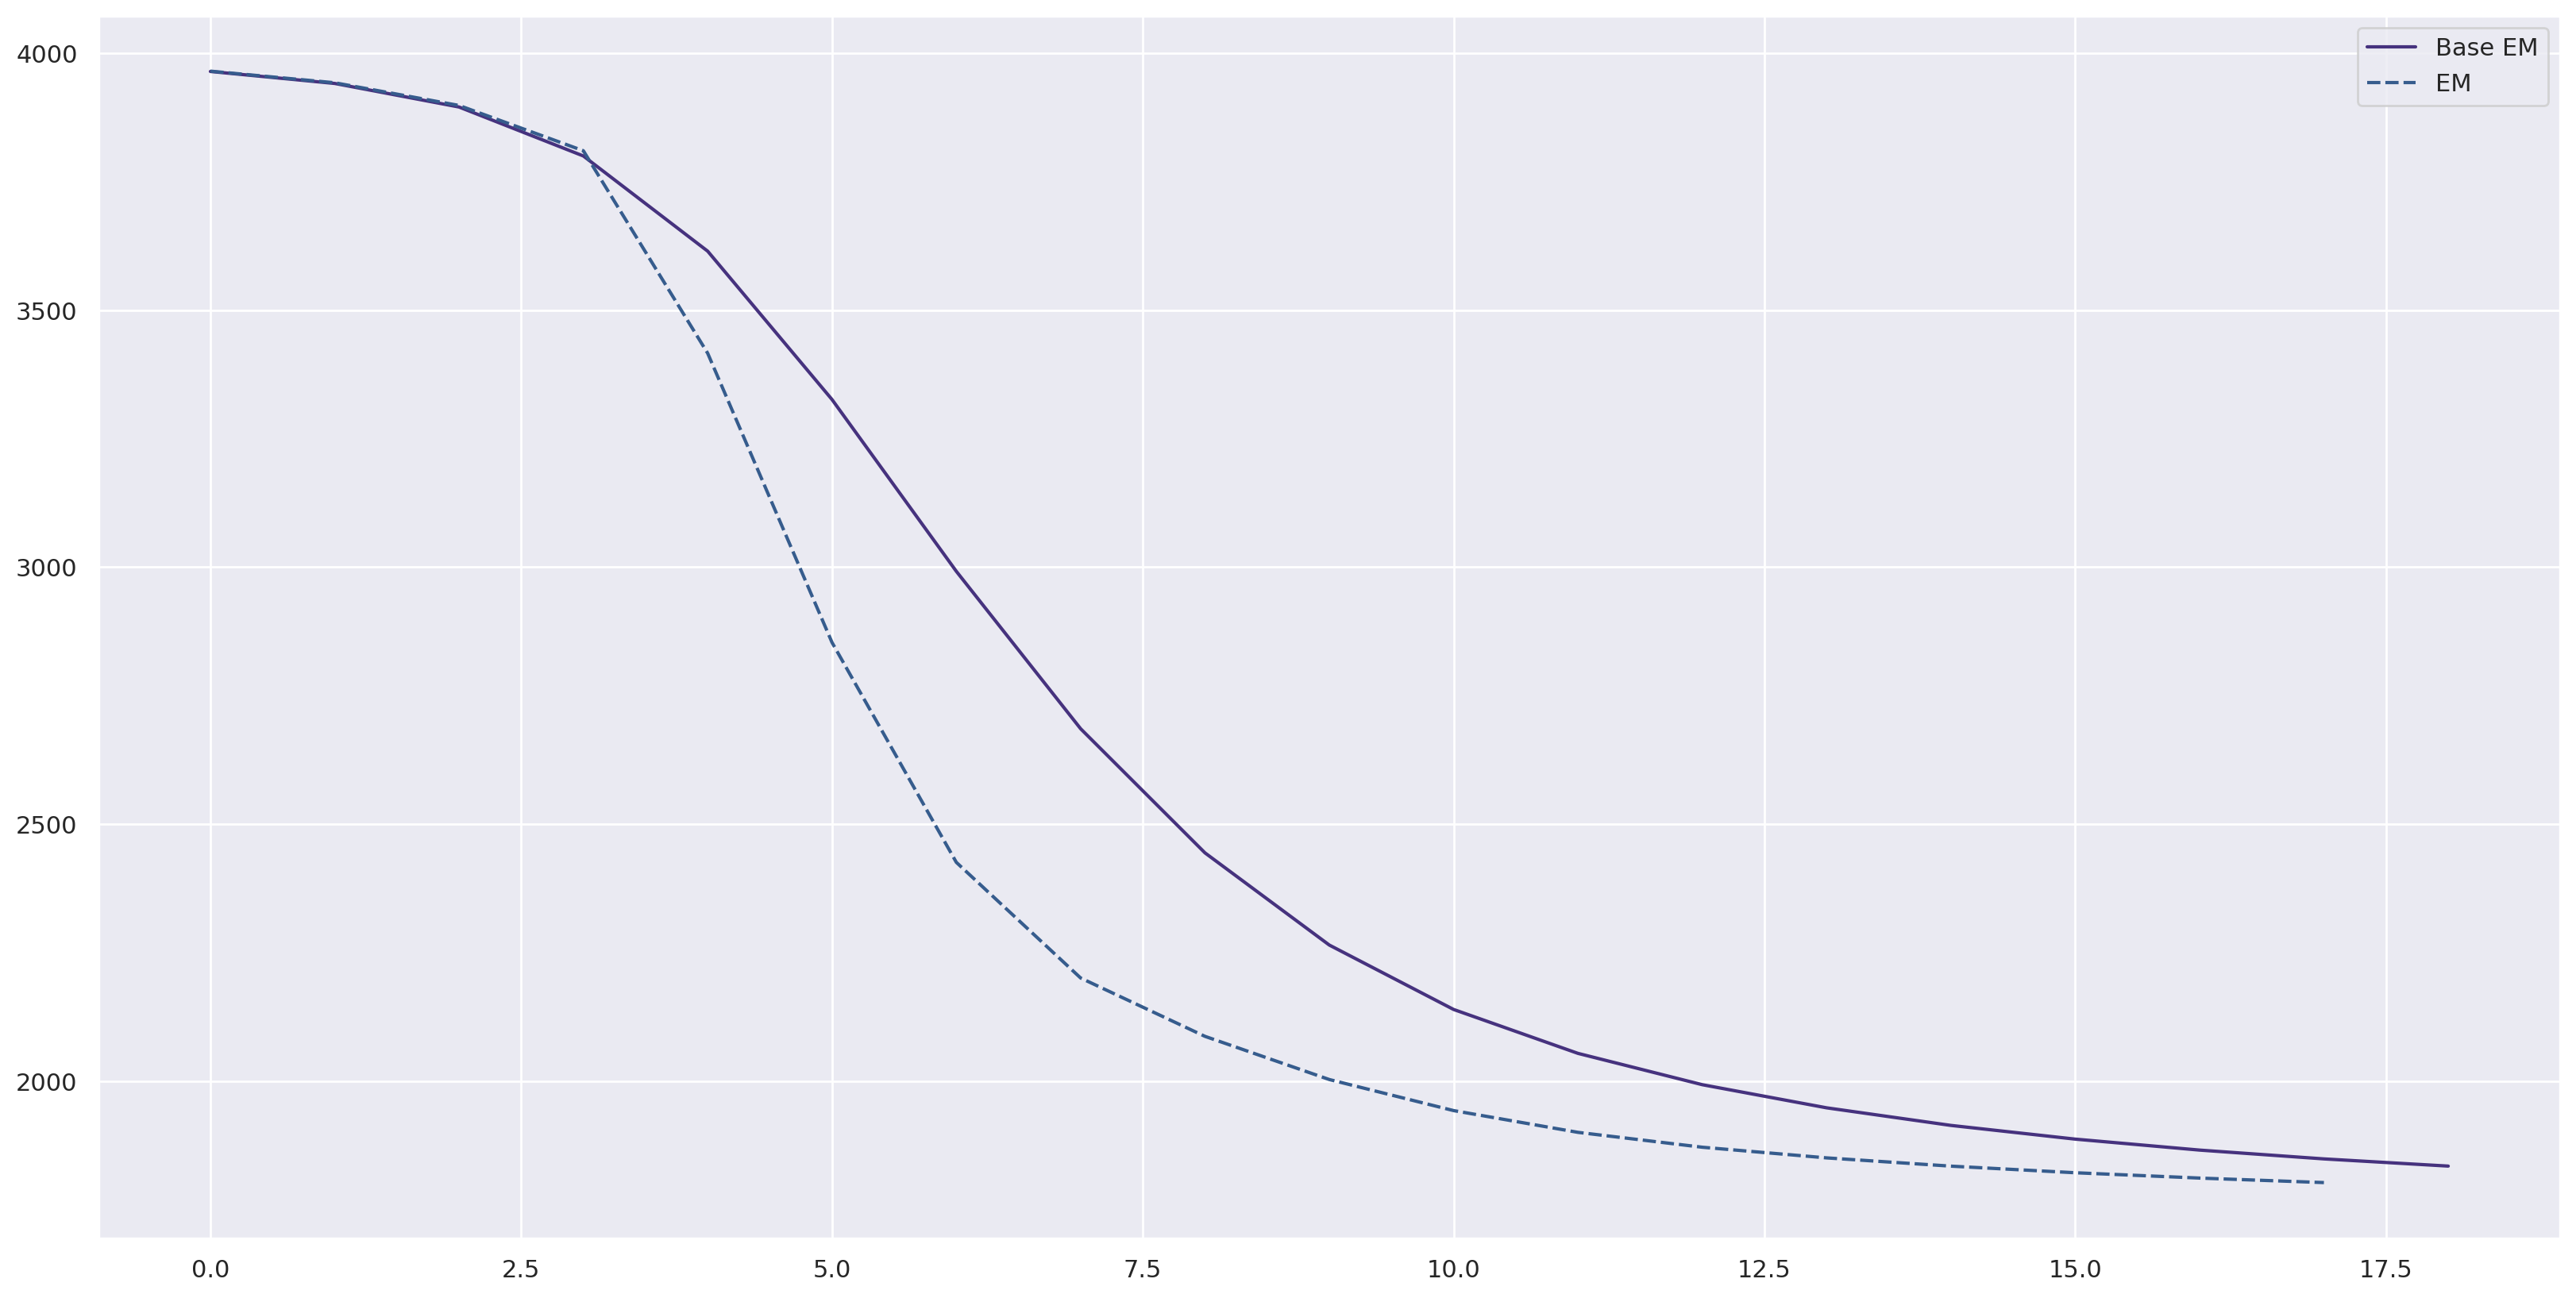

In [62]:
plt.figure(figsize=(10, 5))
sns.lineplot({
    'Thematizer': perplexity_list_1[1:],
    'EM': perplexity_list_3,
})
plt.show()